Loading frames 1 to 101
Frameset: primitives_32, 100 frames with 11 channels JIT enabled
Loading frames 1 to 101
Frameset: primitives_32, 100 frames with 11 channels JIT enabled
Frameset: primitives_low_res_rgb, 100 frames with 1 channels JIT enabled
Frameset: primitives_high_res_rgb, 100 frames with 1 channels JIT enabled
(80, 32, 32, 3)
(20, 32, 32, 3)
(80, 256, 256, 3)
(20, 256, 256, 3)
(80, 32, 32, 3)
(20, 32, 32, 3)
(80, 256, 256, 3)
(20, 256, 256, 3)
(80, 32, 32, 3)
(20, 32, 32, 3)
(80, 256, 256, 3)
(20, 256, 256, 3)


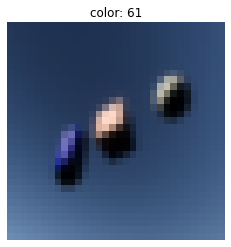

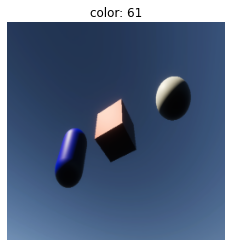

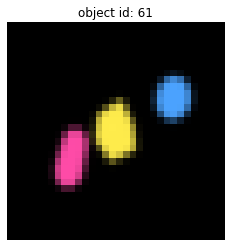

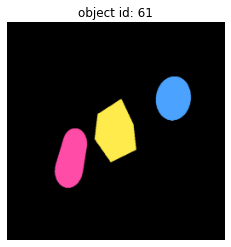

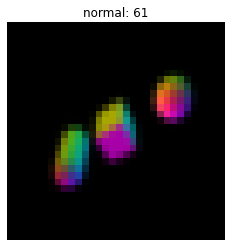

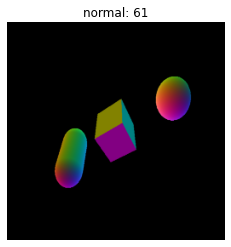

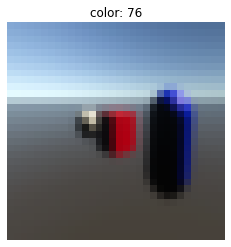

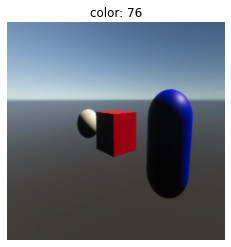

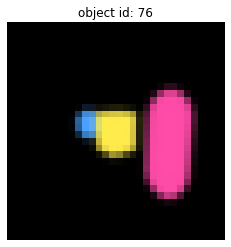

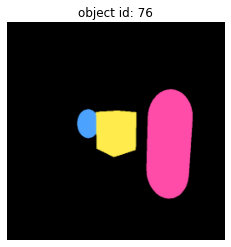

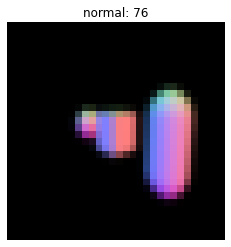

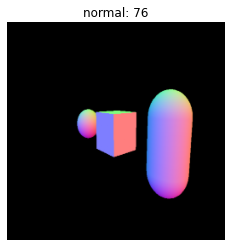

In [1]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

strFramesetNameLowRes = 'primitives_32'
strFramesetNameHighRes = 'primitives_256'
img_size = 32
batch_size = 128
test_batch_size = 128
#num_frames = 4900
num_frames = 100

primitives_low_res = frameset(strFramesetNameLowRes, num_frames=num_frames, fJITLoading=True, fVerbose=False)
primitives_low_res.Print()

primitives_high_res = frameset(strFramesetNameHighRes, num_frames=num_frames, fJITLoading=True, fVerbose=False)
primitives_low_res.Print()

# Split up into RGB and respective target framesets
primitives_low_res_rgb = frameset(
    sourceFrameset=primitives_low_res, 
    strNewFramesetName="primitives_low_res_rgb", 
    sourceChannels=['Color']
)

primitives_high_res_rgb = frameset(
    sourceFrameset=primitives_high_res, 
    strNewFramesetName="primitives_high_res_rgb", 
    sourceChannels=['Color']
)

primitives_low_res_id = frameset(
    sourceFrameset=primitives_low_res, 
    strNewFramesetName="primitives_low_res_id", 
    sourceChannels=['object id']
)

primitives_high_res_id = frameset(
    sourceFrameset=primitives_high_res, 
    strNewFramesetName="primitives_high_res_id", 
    sourceChannels=['object id']
)

primitives_low_res_normal = frameset(
    sourceFrameset=primitives_low_res, 
    strNewFramesetName="primitives_low_res_normal", 
    sourceChannels=['normal']
)

primitives_high_res_normal = frameset(
    sourceFrameset=primitives_high_res, 
    strNewFramesetName="primitives_high_res_normal", 
    sourceChannels=['normal']
)

primitives_low_res_rgb.Print()
#primitives_low_res_rgb[0].visualize()

primitives_high_res_rgb.Print()
#primitives_high_res_rgb[0].visualize()

# split into train and test

primitives_low_res_rgb_train, primitives_low_res_rgb_test = primitives_low_res_rgb.split_into_train_and_test(0.8)
print(primitives_low_res_rgb_train.shape())
print(primitives_low_res_rgb_test.shape())
train_idx = primitives_low_res_rgb_train.get_frame_ids()
test_idx = primitives_low_res_rgb_test.get_frame_ids()

primitives_high_res_rgb_train, primitives_high_res_rgb_test = primitives_high_res_rgb.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(primitives_high_res_rgb_train.shape())
print(primitives_high_res_rgb_test.shape())

primitives_low_res_id_train, primitives_low_res_id_test = primitives_low_res_id.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(primitives_low_res_id_train.shape())
print(primitives_low_res_id_test.shape())

primitives_high_res_id_train, primitives_high_res_id_test = primitives_high_res_id.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(primitives_high_res_id_train.shape())
print(primitives_high_res_id_test.shape())

primitives_low_res_normal_train, primitives_low_res_normal_test = primitives_low_res_normal.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(primitives_low_res_id_train.shape())
print(primitives_low_res_id_test.shape())

primitives_high_res_normal_train, primitives_high_res_normal_test = primitives_high_res_normal.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(primitives_high_res_normal_train.shape())
print(primitives_high_res_normal_test.shape())

# Confirm the match-up
primitives_low_res_rgb_train[3].visualize()
primitives_high_res_rgb_train[3].visualize()
primitives_low_res_id_train[3].visualize()
primitives_high_res_id_train[3].visualize()
primitives_low_res_normal_train[3].visualize()
primitives_high_res_normal_train[3].visualize()

primitives_low_res_rgb_test[1].visualize()
primitives_high_res_rgb_test[1].visualize()
primitives_low_res_id_test[1].visualize()
primitives_high_res_id_test[1].visualize()
primitives_low_res_normal_test[1].visualize()
primitives_high_res_normal_test[1].visualize()

In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

# Conv U-Net

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.ConvUNet import ConvUNet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.ConvUNetTorchSolver import ConvUNetTorchSolver
from repos.pyjunk.models.modules.SSIMModule import SSIMModule

# Set up model
num_low_rgb, H_low_rgb, W_low_rgb, C_low_rgb = primitives_low_res_rgb_train.shape()
num_high_rgb, H_high_rgb, W_high_rgb, C_high_rgb = primitives_high_res_rgb_train.shape()

batch_size = 20
test_batch_size = 5

print("input dims: %d, %d, %d" % (H_low_rgb, W_low_rgb, C_low_rgb))
print("target dims: %d, %d, %d" % (H_high_rgb, W_high_rgb, C_high_rgb))

modelConvUNet = ConvUNet(
#     input_shape=(H_high_rgb, W_high_rgb, C_high_rgb),
#     output_shape=(H_high_rgb, W_high_rgb, C_high_rgb),
    input_shape=(H_low_rgb, W_low_rgb, C_low_rgb),
    output_shape=(H_low_rgb, W_low_rgb, C_low_rgb),
    scale=3, 
    num_filters=32
)

# modelConvUNet = ConvUNet(
#     input_shape=(H_low_rgb, W_low_rgb, C_low_rgb),
#     scale=3, 
#     num_filters=32
# )

# # test SSIM
# testSSIM = SSIMModule(
#     window_size=11, 
#     sigma=1.5
# )

# # # SSIM on same image should be approx 1.0
# npFrameBuffer = primitives_high_res_rgb_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# ssim_val = testSSIM.forward(torchImageBuffer, torchImageBuffer)
# print(ssim_val)

# # Test model
# npFrameBuffer = primitives_high_res_rgb_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# #print(torchImageBuffer.shape)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# out, skip = modelConvUNet.encoder.forward(torchImageBuffer)
# x_tild = modelConvUNet.decoder.forward(out, skip)

# # Test model loss
# npFrameBuffer = primitives_high_res_rgb_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# loss = modelConvUNet.loss(torchImageBuffer, torchImageBuffer)
# print(loss)

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 10000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'checkpoint_file_name': "recon_UNet_checkpoint.tar",
    'checkpoint_epochs': 10,
    'save_test_file_name': "recon_SSUNet.png"
}

# Train on frameset 
# TODO: This is just reconstructing the dataset
solver = ConvUNetTorchSolver(modelConvUNet, dictSolverParams)
# solver.train_frameset_and_plot_losses(
#     train_frameset=primitives_high_res_rgb_train, train_target_frameset=primitives_high_res_rgb_train,
#     test_frameset=primitives_high_res_rgb_test, test_target_frameset=primitives_high_res_rgb_test,
#     fVerbose=True)

# # Lets target the id high res bruv
# solver.train_frameset_and_plot_losses(
#     train_frameset=primitives_high_res_rgb_train, train_target_frameset=primitives_high_res_id_train,
#     test_frameset=primitives_high_res_rgb_test, test_target_frameset=primitives_high_res_id_test,
#     fVerbose=True)

# Lets target the id low res bruv
solver.train_frameset_and_plot_losses(
    train_frameset=primitives_low_res_rgb_train, train_target_frameset=primitives_low_res_id_train,
    test_frameset=primitives_low_res_rgb_test, test_target_frameset=primitives_low_res_id_test,
    fVerbose=True)

# # Lets target the normals high res bruv
# solver.train_frameset_and_plot_losses(
#     train_frameset=primitives_high_res_rgb_train, train_target_frameset=primitives_high_res_normal_train,
#     test_frameset=primitives_high_res_rgb_test, test_target_frameset=primitives_high_res_normal_test,
#     fVerbose=True)

# # Lets target the normals low res bruv
# solver.train_frameset_and_plot_losses(
#     train_frameset=primitives_low_res_rgb_train, train_target_frameset=primitives_low_res_normal_train,
#     test_frameset=primitives_low_res_rgb_test, test_target_frameset=primitives_low_res_normal_test,
#     fVerbose=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
input dims: 32, 32, 3
target dims: 256, 256, 3
3
enc first: 3 - 32
enc inner: 32 - 64
enc final: 64 - 128
dec first: 128 - 64
dec inner: 128 - 64 - 32
dec final: 64 - 32 - 3
training on frames [13, 5, 50, 8, 45, 58, 1, 69, 16, 66, 70, 63, 17, 40, 29, 21, 57, 12, 39, 67] in frameset primitives_low_res_rgb_train
testing on frames [6, 1, 0, 19, 7] in frameset primitives_low_res_rgb_test
Epoch 0, Test loss 0.4728
training on frames [12, 66, 2, 6, 3, 7, 32, 60, 47, 71, 59, 56, 20, 72, 11, 73, 64, 44, 53, 13] in frameset primitives_low_res_rgb_train
testing on frames [12, 2, 5, 18, 11] in frameset primitives_low_res_rgb_test
Epoch 1, Test loss 0.4703
training on frames [56, 58, 76, 48, 0, 65, 41, 49, 18, 34, 4, 1, 26, 54, 74, 21, 13, 9, 23, 5] in frameset primitives_low_res_rgb_train
testing on frames [11, 8, 15, 5, 10] in frameset primitives_low_res_rgb_test
Epoch 2, Test loss 0.4593
training on frames [

testing on frames [1, 7, 0, 2, 16] in frameset primitives_low_res_rgb_test
Epoch 32, Test loss 0.0828
training on frames [59, 22, 76, 4, 37, 13, 57, 9, 2, 54, 79, 78, 20, 30, 62, 0, 17, 32, 60, 77] in frameset primitives_low_res_rgb_train
testing on frames [4, 6, 7, 14, 15] in frameset primitives_low_res_rgb_test
Epoch 33, Test loss 0.0578
training on frames [34, 51, 16, 74, 47, 68, 76, 33, 27, 11, 79, 38, 52, 67, 5, 1, 64, 21, 42, 32] in frameset primitives_low_res_rgb_train
testing on frames [13, 5, 15, 0, 12] in frameset primitives_low_res_rgb_test
Epoch 34, Test loss 0.0660
training on frames [77, 12, 13, 18, 53, 26, 64, 67, 62, 63, 29, 50, 32, 37, 35, 46, 76, 42, 23, 11] in frameset primitives_low_res_rgb_train
testing on frames [0, 16, 13, 15, 9] in frameset primitives_low_res_rgb_test
Epoch 35, Test loss 0.0742
training on frames [26, 65, 3, 50, 42, 49, 52, 66, 28, 64, 44, 7, 37, 20, 19, 79, 29, 46, 72, 11] in frameset primitives_low_res_rgb_train
testing on frames [6, 14, 19, 1

testing on frames [0, 15, 5, 1, 12] in frameset primitives_low_res_rgb_test
Epoch 65, Test loss 0.0373
training on frames [33, 26, 48, 35, 69, 73, 66, 23, 75, 41, 40, 56, 57, 46, 0, 17, 76, 7, 59, 14] in frameset primitives_low_res_rgb_train
testing on frames [18, 16, 15, 17, 10] in frameset primitives_low_res_rgb_test
Epoch 66, Test loss 0.0415
training on frames [47, 26, 42, 13, 10, 18, 48, 79, 32, 50, 25, 72, 77, 51, 41, 58, 45, 34, 69, 66] in frameset primitives_low_res_rgb_train


KeyboardInterrupt: 

In [4]:
import torch

strCheckpoint = "ConvUNet_checkpoint.tar"

solver.SaveCheckpoint(strCheckpoint, 0, 0)

In [5]:
import torch

strCheckpoint = "ConvUNet_checkpoint.tar"

solver.LoadCheckpoint(strCheckpoint)

(0, 0)

In [7]:
import torch

dictSolverParams = {
    'lr': 1e-4,
    'epochs': 1000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size
}

# Lets target the normals bruv
solver.train_frameset_and_plot_losses(
    train_frameset=primitives_low_res_rgb_train, train_target_frameset=primitives_low_res_id_train,
    test_frameset=primitives_low_res_rgb_test, test_target_frameset=primitives_low_res_id_test,
    fVerbose=True)

training on frames [299, 2167, 82, 2069, 2497, 3782, 1366, 2682, 797, 31, 1592, 1899, 385, 3258, 2183, 2967, 135, 2376, 1918, 1102, 2142, 2602, 825, 2650, 1842, 1706, 3253, 3377, 2389, 252, 1025, 3283, 3387, 2750, 703, 1093, 2999, 507, 1760, 1345, 1823, 118, 2320, 1581, 921, 3825, 157, 2759, 2692, 1661, 86, 3423, 1913, 159, 1558, 29, 1152, 3841, 2031, 2488, 761, 1535, 692, 1590, 3213, 2432, 1934, 3168, 2185, 224, 2354, 3249, 739, 2197, 3749, 2842, 1518, 3352, 1389, 3815, 1020, 3838, 2542, 1265, 2860, 2965, 3543, 2775, 2272, 1656, 1906, 2406, 73, 2670, 284, 464, 3638, 1030, 869, 2191, 2241, 887, 3211, 2876, 3741, 3319, 1595, 2027, 227, 2903, 3489, 915, 1162, 3005, 1682, 2910, 1869, 3007, 1200, 1829, 2008, 3647, 3500, 821, 2887, 3655, 3504, 2221] in frameset primitivesRGB_train
testing on frames [594, 45, 433, 925, 878, 359, 934, 635, 3, 262, 416, 701, 506, 380, 247, 21, 175, 194, 694, 42] in frameset primitivesRGB_test
Epoch 0, Test loss 10.1947
training on frames [543, 3053, 2790, 965,

testing on frames [891, 748, 811, 752, 217, 902, 487, 691, 234, 508, 445, 192, 884, 936, 438, 172, 744, 363, 334, 978] in frameset primitivesRGB_test
Epoch 8, Test loss 10.9579
training on frames [1235, 2164, 2191, 1825, 3772, 959, 154, 3331, 3498, 3224, 281, 769, 551, 192, 2280, 407, 1344, 1839, 3018, 1748, 2563, 3032, 3089, 2862, 2561, 917, 3670, 815, 3605, 798, 466, 3374, 485, 1506, 2930, 2225, 3701, 621, 1932, 3491, 1216, 1104, 3172, 238, 674, 1961, 977, 344, 1770, 1422, 3361, 2068, 1395, 3028, 2113, 596, 1272, 1483, 204, 3364, 3041, 301, 3832, 260, 1050, 2450, 3231, 556, 3368, 2843, 1186, 1193, 1855, 1456, 1487, 3666, 3065, 3734, 3571, 3061, 818, 1234, 2660, 2483, 1646, 115, 2817, 1814, 675, 1823, 96, 1736, 3297, 496, 3538, 2086, 1444, 3315, 3441, 2125, 1363, 223, 523, 1302, 848, 3824, 2434, 8, 3337, 1547, 1217, 883, 1894, 590, 2431, 749, 365, 2285, 1893, 2778, 544, 611, 3323, 1223, 584, 1162, 1273, 2593] in frameset primitivesRGB_train
testing on frames [706, 561, 441, 773, 662, 

testing on frames [865, 939, 380, 832, 894, 844, 159, 104, 280, 219, 419, 955, 299, 429, 347, 954, 766, 160, 499, 324] in frameset primitivesRGB_test
Epoch 17, Test loss 10.1968
training on frames [317, 1828, 3081, 1593, 283, 2256, 123, 3055, 1650, 696, 2066, 1794, 416, 9, 3522, 3714, 3787, 2642, 816, 2321, 2562, 1679, 2055, 101, 315, 2548, 3665, 2513, 738, 2669, 2438, 1286, 249, 2635, 715, 473, 2621, 3533, 785, 862, 1188, 41, 3728, 2743, 1902, 2873, 1793, 3662, 1755, 1099, 1080, 3229, 1134, 1221, 2773, 2444, 1362, 3709, 2852, 1031, 31, 2639, 728, 1702, 2057, 810, 1999, 326, 1734, 958, 3696, 433, 3636, 3554, 191, 1768, 1935, 2602, 880, 3009, 3, 3584, 732, 1001, 56, 2740, 3739, 977, 2411, 1189, 3811, 320, 3568, 1021, 2705, 2803, 3896, 639, 3123, 467, 1192, 3400, 2006, 3136, 2433, 3818, 3774, 2275, 2081, 2692, 1719, 1532, 32, 1319, 2329, 2416, 3795, 1541, 648, 1147, 3273, 2810, 1427, 3166, 663, 430, 2571, 1060] in frameset primitivesRGB_train
testing on frames [475, 820, 84, 605, 487, 92

testing on frames [744, 900, 682, 114, 334, 346, 45, 47, 571, 637, 859, 652, 497, 67, 448, 480, 612, 160, 204, 197] in frameset primitivesRGB_test
Epoch 26, Test loss 11.9116
training on frames [3777, 1531, 3474, 2566, 3238, 2041, 2447, 2932, 595, 805, 2064, 3614, 1859, 1976, 1114, 1968, 2764, 1616, 554, 3807, 2258, 2908, 107, 2924, 2080, 2368, 2771, 2567, 3549, 1472, 2469, 2790, 3281, 2269, 96, 2280, 236, 1299, 716, 667, 252, 3382, 1903, 69, 892, 969, 1161, 840, 1652, 1757, 2631, 3339, 782, 1040, 233, 2965, 864, 232, 8, 3107, 115, 1556, 1861, 3728, 3013, 1755, 889, 3246, 1144, 180, 2754, 166, 1024, 2015, 1723, 2452, 3755, 3870, 1128, 3164, 1447, 51, 501, 3072, 1149, 1583, 3472, 2339, 1350, 974, 647, 2612, 3089, 855, 2097, 731, 314, 1676, 488, 3347, 839, 3161, 2267, 3507, 265, 736, 1751, 2463, 2018, 3444, 2201, 3244, 795, 3886, 1480, 700, 1640, 1496, 3467, 772, 995, 1234, 173, 3686, 230, 1485, 2194, 2182] in frameset primitivesRGB_train
testing on frames [571, 676, 609, 522, 926, 499, 

testing on frames [650, 534, 693, 47, 398, 343, 44, 663, 260, 39, 498, 158, 974, 27, 78, 709, 852, 558, 479, 92] in frameset primitivesRGB_test
Epoch 35, Test loss 11.1582
training on frames [1827, 2944, 347, 2119, 2497, 3547, 3092, 2808, 2694, 2936, 795, 719, 532, 3754, 588, 382, 579, 1567, 3298, 1170, 3220, 2954, 3761, 1694, 1722, 3204, 1328, 3192, 2477, 1276, 482, 1685, 3103, 1845, 2087, 3641, 1946, 1011, 3854, 534, 3142, 3328, 789, 1956, 3016, 798, 2479, 3646, 2350, 2597, 2156, 3384, 2984, 3338, 1219, 3422, 249, 3735, 1652, 1212, 871, 1539, 405, 3736, 160, 1768, 1546, 1690, 1899, 41, 686, 610, 635, 3638, 785, 2377, 2720, 460, 453, 2960, 2338, 3085, 474, 1366, 2527, 1673, 1544, 2419, 630, 2488, 2619, 216, 1910, 275, 576, 3258, 3667, 1029, 3332, 1454, 1254, 2293, 310, 200, 2541, 187, 451, 1821, 302, 2054, 2264, 1953, 1017, 1261, 2703, 2199, 2978, 3569, 406, 2192, 2019, 318, 2009, 2774, 2934, 1077, 1820, 1385] in frameset primitivesRGB_train
testing on frames [130, 281, 818, 377, 646,

testing on frames [478, 548, 796, 782, 616, 364, 449, 819, 527, 343, 762, 85, 936, 366, 738, 387, 120, 309, 535, 425] in frameset primitivesRGB_test
Epoch 44, Test loss 11.7542
training on frames [164, 2042, 145, 2155, 730, 3327, 3696, 2056, 2029, 2994, 2872, 1203, 3435, 405, 68, 2422, 1799, 3071, 616, 2389, 2027, 206, 2162, 2100, 2660, 2453, 3473, 3166, 2373, 2310, 1575, 1086, 463, 1748, 979, 6, 2946, 1416, 2525, 2574, 134, 3151, 3413, 1992, 2450, 1534, 2164, 1577, 3687, 1503, 3872, 2675, 1831, 238, 57, 2452, 2544, 2245, 1169, 2280, 3463, 3844, 3469, 751, 1018, 1190, 1059, 3443, 2351, 1893, 1402, 2514, 1743, 3710, 1430, 2674, 1882, 660, 3611, 118, 872, 785, 91, 2178, 3497, 2835, 1374, 3739, 3414, 3083, 1843, 1446, 2620, 1471, 782, 2427, 3287, 3804, 3117, 1487, 141, 1720, 3061, 3030, 2642, 406, 1447, 1818, 3686, 3599, 2579, 3869, 1900, 3336, 2787, 3496, 488, 3424, 2429, 3181, 2650, 3431, 267, 3439, 3450, 2808, 1120, 1902] in frameset primitivesRGB_train
testing on frames [446, 250, 619

testing on frames [944, 209, 683, 515, 128, 365, 693, 754, 433, 265, 272, 722, 424, 461, 259, 518, 323, 437, 834, 462] in frameset primitivesRGB_test
Epoch 53, Test loss 10.4724
training on frames [3679, 2605, 1947, 589, 3134, 2618, 2323, 1477, 267, 546, 233, 329, 2606, 110, 1791, 3154, 16, 2215, 3182, 1741, 3151, 88, 2152, 339, 3031, 354, 1619, 2466, 2495, 3302, 2243, 3742, 406, 1575, 2149, 2516, 115, 3817, 404, 421, 3445, 2489, 2985, 2450, 1566, 1215, 291, 986, 2752, 2798, 826, 2619, 248, 13, 3376, 3016, 2226, 574, 3410, 736, 1762, 2573, 2844, 2442, 2263, 2482, 2665, 2254, 1371, 2688, 3509, 2375, 2422, 3465, 649, 2328, 1869, 583, 1728, 563, 1644, 3699, 319, 3351, 1300, 2673, 211, 1192, 1204, 943, 1181, 3735, 1052, 1750, 980, 1883, 1829, 3112, 1599, 1103, 228, 1683, 43, 282, 2541, 631, 548, 3236, 3790, 1816, 3586, 813, 2301, 682, 2144, 3003, 342, 3524, 3677, 3294, 506, 1151, 1852, 47, 2705, 3321, 2760, 2303] in frameset primitivesRGB_train
testing on frames [119, 318, 60, 472, 449, 23

testing on frames [961, 722, 627, 38, 63, 747, 673, 678, 82, 235, 775, 64, 573, 172, 836, 236, 431, 5, 481, 323] in frameset primitivesRGB_test
Epoch 62, Test loss 10.8386
training on frames [191, 3204, 207, 3186, 3361, 3747, 3769, 2369, 2513, 326, 2678, 2266, 3447, 601, 1520, 2209, 3755, 3334, 3045, 1888, 2270, 3807, 1455, 1967, 251, 1141, 2681, 619, 214, 638, 1013, 2838, 2739, 3882, 2751, 3505, 1857, 3254, 2466, 2505, 2883, 2030, 2805, 2569, 3613, 3672, 2720, 468, 1903, 2901, 2576, 2875, 2685, 3860, 59, 3288, 1137, 1086, 2499, 1968, 2602, 3544, 507, 2403, 406, 1756, 2202, 3032, 2012, 1422, 1562, 3365, 114, 549, 1830, 2340, 149, 1027, 1079, 1711, 3119, 1557, 2167, 3016, 3917, 2776, 2844, 1831, 533, 2349, 238, 1580, 1397, 596, 186, 2810, 215, 1120, 1855, 2757, 1238, 423, 249, 2662, 1549, 2853, 3536, 3221, 2983, 746, 3852, 940, 1458, 2372, 1896, 127, 1115, 3751, 3070, 3409, 2278, 2309, 2543, 2188, 2697, 2981, 1368, 3483] in frameset primitivesRGB_train
testing on frames [171, 300, 490, 

testing on frames [753, 378, 120, 581, 381, 364, 363, 377, 317, 368, 335, 38, 905, 231, 521, 286, 8, 852, 506, 896] in frameset primitivesRGB_test
Epoch 71, Test loss 11.0239
training on frames [1576, 2319, 102, 1192, 3175, 3908, 1578, 919, 1420, 411, 1759, 1965, 1122, 1238, 1539, 883, 3421, 860, 850, 399, 1874, 2774, 1125, 154, 3461, 987, 2163, 704, 252, 2950, 201, 256, 1310, 1054, 3029, 1913, 2101, 3061, 595, 3529, 3532, 1161, 2394, 473, 933, 2119, 2131, 1369, 3065, 3309, 3260, 3411, 2385, 461, 471, 3815, 2240, 245, 979, 1410, 2680, 1603, 1433, 175, 2429, 140, 446, 1928, 3235, 3756, 483, 1128, 3241, 3495, 3406, 527, 3871, 2695, 2133, 643, 3657, 2195, 157, 1147, 3593, 742, 2686, 3682, 2679, 897, 2047, 2381, 2256, 1704, 3139, 1469, 1402, 3233, 1008, 2050, 3188, 1087, 1323, 3726, 832, 2462, 487, 80, 122, 3118, 2145, 53, 1228, 2501, 1354, 1598, 2006, 934, 2778, 2999, 1066, 810, 780, 1283, 3273, 3306, 2902, 3888] in frameset primitivesRGB_train
testing on frames [689, 24, 624, 237, 495, 9

testing on frames [688, 355, 156, 679, 598, 740, 831, 958, 338, 343, 228, 397, 469, 857, 955, 209, 663, 414, 236, 450] in frameset primitivesRGB_test
Epoch 80, Test loss 10.7183
training on frames [107, 1121, 3571, 2471, 3375, 1886, 3779, 2940, 3620, 573, 528, 2121, 590, 917, 2206, 1221, 942, 3252, 3449, 3824, 2249, 446, 12, 2069, 2801, 2453, 1550, 2180, 3704, 1308, 621, 2787, 2412, 3301, 1544, 2996, 2924, 3369, 3650, 1243, 3042, 2205, 1266, 1231, 2210, 219, 3126, 736, 487, 511, 3796, 2415, 2601, 2855, 3363, 370, 1455, 869, 1138, 3558, 918, 10, 1425, 1214, 2759, 3843, 920, 1584, 1822, 3115, 1406, 1327, 1491, 1700, 2558, 3104, 2908, 1906, 3453, 1904, 2843, 3294, 2287, 2911, 1683, 2419, 1856, 350, 2102, 306, 2448, 1890, 880, 3852, 3829, 373, 523, 1588, 2399, 3411, 2397, 2062, 3510, 3475, 2839, 1673, 3415, 637, 613, 3597, 2048, 1813, 2504, 3040, 1527, 1287, 1286, 3029, 2979, 1628, 2654, 824, 1992, 2231, 322, 768, 427, 2659] in frameset primitivesRGB_train
testing on frames [124, 712, 400,

testing on frames [211, 376, 87, 415, 149, 544, 734, 316, 894, 281, 724, 117, 224, 19, 325, 143, 978, 128, 876, 675] in frameset primitivesRGB_test
Epoch 89, Test loss 9.3675
training on frames [1581, 1651, 1897, 1312, 1203, 260, 2925, 540, 3468, 2425, 3875, 2927, 3690, 2485, 421, 903, 3278, 1046, 2451, 311, 1612, 3594, 175, 3740, 2694, 578, 2390, 568, 2089, 3834, 2472, 1662, 1443, 3548, 1714, 1484, 2055, 3803, 2755, 448, 2830, 3263, 922, 84, 1748, 2227, 2386, 1309, 369, 23, 2475, 1064, 2263, 2802, 74, 1020, 107, 457, 653, 2194, 2720, 2051, 1394, 3379, 706, 1214, 2282, 3174, 93, 937, 3808, 2529, 949, 2198, 524, 533, 3268, 2827, 1807, 2681, 2621, 3599, 2092, 3537, 1001, 634, 3847, 3802, 2380, 1666, 1015, 3049, 3463, 734, 276, 3369, 978, 158, 415, 2295, 1371, 3716, 2403, 3830, 1839, 516, 2762, 3149, 2030, 3429, 3546, 652, 2517, 3197, 750, 3001, 133, 80, 2350, 3481, 1103, 802, 2791, 3132, 376, 1660, 487, 1201] in frameset primitivesRGB_train
testing on frames [688, 414, 113, 459, 841, 250

testing on frames [191, 346, 875, 310, 740, 573, 393, 41, 513, 29, 88, 210, 267, 469, 629, 950, 843, 81, 261, 71] in frameset primitivesRGB_test
Epoch 98, Test loss 11.4360
training on frames [3183, 3623, 1880, 3745, 742, 3636, 2998, 282, 133, 933, 3707, 2204, 3012, 149, 1960, 1590, 2067, 3564, 2439, 1259, 3834, 104, 3365, 1883, 2419, 2300, 2966, 2307, 873, 353, 1004, 3106, 2340, 1207, 2778, 1344, 965, 52, 2809, 1489, 1433, 234, 936, 1900, 3494, 2278, 2242, 1546, 2193, 1599, 3404, 1379, 2752, 3203, 3247, 220, 3661, 2259, 3844, 370, 847, 2656, 3801, 207, 2781, 473, 602, 2530, 3082, 3609, 2687, 1389, 1248, 2349, 2931, 637, 1768, 3024, 1394, 96, 2395, 373, 3154, 708, 3749, 1706, 1891, 2293, 2898, 972, 1479, 1047, 1848, 2532, 2907, 2001, 2646, 3505, 1557, 1559, 3648, 2135, 2195, 3448, 70, 3870, 2710, 989, 1879, 2137, 178, 1132, 881, 1849, 2154, 1053, 1689, 2356, 2635, 2636, 2114, 1712, 2352, 44, 3787, 1944, 342, 1814] in frameset primitivesRGB_train
testing on frames [557, 543, 608, 53, 63

testing on frames [341, 390, 605, 324, 106, 362, 565, 144, 712, 415, 85, 479, 57, 846, 561, 563, 733, 718, 299, 20] in frameset primitivesRGB_test
Epoch 107, Test loss 10.4366
training on frames [2997, 825, 931, 1204, 3027, 774, 406, 3133, 91, 739, 2477, 2849, 1591, 219, 1817, 950, 402, 1243, 977, 421, 318, 1543, 2588, 3109, 2959, 3916, 2983, 1673, 887, 2676, 626, 1787, 1914, 1133, 2616, 2791, 3216, 2451, 15, 1434, 346, 944, 3708, 167, 3061, 3374, 2343, 1499, 148, 1833, 2761, 2095, 3828, 2487, 456, 2192, 2495, 70, 3150, 877, 1198, 3709, 3371, 1336, 2390, 422, 517, 1445, 2061, 1354, 1035, 492, 1594, 1590, 3310, 2304, 3260, 1322, 3065, 2684, 3753, 3390, 1936, 264, 767, 2272, 1494, 956, 3675, 3435, 3098, 3644, 855, 1075, 633, 1284, 3262, 3825, 217, 3556, 1716, 2258, 1545, 2082, 995, 1765, 2435, 1258, 3736, 1468, 306, 815, 2205, 3587, 742, 1357, 2732, 424, 612, 2269, 2083, 1924, 1627, 3264, 2705, 969, 2208, 3203] in frameset primitivesRGB_train
testing on frames [377, 135, 833, 790, 225, 6

testing on frames [219, 93, 421, 119, 390, 632, 120, 284, 716, 24, 580, 393, 8, 452, 908, 394, 756, 565, 755, 647] in frameset primitivesRGB_test
Epoch 116, Test loss 10.5017
training on frames [1305, 1595, 2566, 1019, 1365, 1596, 405, 113, 1569, 1476, 437, 3191, 2152, 2229, 1885, 760, 2905, 3589, 786, 1809, 3891, 2513, 1567, 830, 3764, 2512, 402, 169, 2205, 3033, 2684, 944, 1855, 2867, 2574, 2727, 244, 1252, 185, 1471, 138, 3039, 2781, 1790, 3890, 3250, 3717, 2157, 1575, 2274, 2290, 3116, 2597, 478, 2237, 186, 3877, 1299, 1063, 1742, 1898, 2584, 3608, 1534, 2118, 617, 1810, 1601, 1597, 1731, 97, 1572, 2106, 905, 600, 2524, 2481, 766, 338, 3531, 2285, 305, 1351, 2973, 1179, 1796, 2050, 3400, 1636, 3715, 449, 382, 1267, 2160, 2529, 2987, 2577, 2743, 620, 1411, 3576, 1970, 2953, 3762, 1302, 902, 3709, 1707, 624, 3731, 708, 458, 3550, 1541, 2190, 2509, 1846, 3706, 1961, 3690, 2362, 3028, 1519, 3011, 2740, 3724, 319, 2796] in frameset primitivesRGB_train
testing on frames [196, 796, 812, 6

testing on frames [396, 495, 730, 426, 373, 180, 930, 135, 618, 949, 340, 195, 712, 134, 575, 815, 657, 864, 448, 626] in frameset primitivesRGB_test
Epoch 125, Test loss 10.8126
training on frames [2246, 1314, 924, 2470, 2743, 356, 872, 2428, 1804, 1273, 2221, 1130, 3707, 566, 3511, 3239, 3015, 2422, 26, 1457, 177, 1640, 3801, 2949, 3050, 3846, 1247, 2378, 2913, 2616, 2661, 1055, 2967, 2350, 1222, 2641, 3428, 1370, 3323, 3677, 1518, 287, 2219, 1911, 2858, 2987, 853, 1303, 3441, 3751, 1036, 1713, 1695, 2825, 346, 2617, 1233, 2646, 3882, 2364, 2739, 1010, 425, 1511, 352, 1519, 1231, 1791, 1707, 1900, 1736, 365, 2242, 411, 3830, 44, 1472, 3863, 605, 774, 3864, 3572, 3567, 70, 540, 684, 627, 3740, 1967, 137, 577, 609, 2078, 3384, 1652, 2924, 3283, 1799, 1905, 3593, 2284, 883, 2878, 884, 2846, 104, 1891, 1491, 271, 510, 3604, 1830, 3734, 1567, 3753, 3302, 2139, 614, 874, 1784, 3652, 2826, 2375, 1282, 3314, 2996, 3587, 2956] in frameset primitivesRGB_train
testing on frames [43, 33, 676, 83

testing on frames [501, 897, 261, 967, 477, 52, 618, 33, 37, 41, 270, 978, 256, 392, 679, 230, 580, 139, 713, 942] in frameset primitivesRGB_test
Epoch 134, Test loss 10.5811
training on frames [2634, 3739, 3224, 2157, 1643, 2197, 399, 616, 3418, 424, 236, 1584, 161, 1624, 746, 2497, 1992, 2670, 1495, 1311, 3500, 2601, 2769, 2653, 3262, 1686, 724, 157, 1340, 2032, 2193, 3748, 2854, 3236, 2763, 3306, 963, 543, 1714, 1367, 1410, 3658, 3541, 172, 1099, 1971, 2015, 2270, 203, 3320, 803, 1858, 557, 847, 2041, 1646, 699, 1743, 2438, 190, 713, 807, 3889, 3584, 1910, 3837, 3390, 2531, 1301, 201, 828, 3721, 3175, 1413, 2749, 775, 3839, 1326, 908, 1443, 2351, 3213, 2936, 1140, 3510, 406, 1709, 2828, 1439, 3556, 474, 2872, 3152, 1400, 1659, 1831, 2734, 859, 2732, 3492, 3384, 1860, 2205, 693, 3406, 1224, 2993, 2566, 1802, 623, 2552, 3298, 1883, 1687, 2019, 2134, 3178, 2622, 2181, 1141, 2147, 3049, 260, 1861, 2897, 2452, 1304, 2063] in frameset primitivesRGB_train
testing on frames [589, 624, 117, 

testing on frames [341, 591, 971, 210, 744, 36, 494, 361, 13, 91, 783, 947, 315, 776, 323, 449, 438, 886, 869, 765] in frameset primitivesRGB_test
Epoch 143, Test loss 11.2348
training on frames [1044, 2656, 1379, 2354, 2472, 3884, 2997, 3887, 1596, 1813, 3361, 339, 2304, 841, 606, 3025, 765, 3406, 3402, 822, 1866, 2598, 2540, 1884, 512, 2353, 2152, 3866, 1430, 2756, 9, 2545, 1081, 3432, 1385, 597, 2480, 2083, 2899, 2697, 2774, 1665, 950, 1448, 971, 121, 3683, 1940, 2051, 2747, 2290, 2592, 3374, 2799, 1841, 1778, 2615, 3733, 2227, 956, 3674, 2771, 3458, 1478, 479, 3768, 921, 114, 2640, 198, 989, 3412, 3653, 3489, 925, 1517, 1040, 1639, 2343, 3, 3162, 1925, 2198, 1758, 3170, 1037, 1915, 2235, 2594, 1092, 1261, 3645, 729, 118, 291, 1342, 3610, 71, 1351, 855, 278, 988, 3234, 1331, 2946, 2753, 2126, 1305, 2287, 2133, 869, 2366, 835, 1515, 3526, 2316, 1576, 3289, 917, 3492, 2145, 3669, 760, 1857, 2058, 2406, 2161, 2742] in frameset primitivesRGB_train
testing on frames [469, 621, 409, 842, 

testing on frames [871, 194, 138, 366, 249, 846, 608, 406, 238, 132, 771, 481, 177, 549, 17, 115, 101, 248, 302, 345] in frameset primitivesRGB_test
Epoch 152, Test loss 10.1120
training on frames [1899, 2504, 1104, 2550, 1415, 1293, 2883, 2552, 1428, 2602, 2090, 3082, 3518, 2993, 3374, 1374, 2806, 2966, 3298, 3852, 1618, 686, 1237, 417, 565, 689, 1849, 3775, 1378, 1298, 1590, 819, 1255, 3655, 657, 1069, 659, 1574, 2411, 3789, 3457, 1430, 3564, 3150, 2995, 2046, 3627, 3811, 379, 150, 1084, 680, 2991, 3839, 3570, 206, 2957, 2635, 2619, 3891, 3201, 503, 3095, 510, 3629, 418, 730, 3062, 2308, 2257, 475, 3036, 859, 2166, 3688, 284, 3145, 798, 188, 3875, 2872, 485, 3320, 2047, 1109, 447, 96, 3331, 544, 2672, 1211, 1871, 3684, 1823, 2455, 3293, 3639, 457, 2765, 2009, 2906, 2195, 706, 1150, 1311, 1178, 2151, 1748, 1491, 3903, 3081, 3429, 1325, 1333, 2676, 41, 840, 1292, 2726, 2404, 2711, 931, 1945, 1267, 357, 1090, 1531, 1335] in frameset primitivesRGB_train
testing on frames [619, 525, 676, 

testing on frames [790, 814, 455, 867, 644, 129, 299, 396, 247, 858, 740, 712, 628, 532, 776, 562, 135, 86, 710, 906] in frameset primitivesRGB_test
Epoch 161, Test loss 9.9926
training on frames [2546, 65, 1752, 2436, 2547, 1826, 472, 116, 3063, 3583, 1999, 1274, 750, 3379, 710, 2862, 2713, 2187, 2280, 983, 1050, 2617, 1211, 2592, 2739, 61, 2811, 1382, 729, 2830, 2255, 1433, 2201, 3668, 248, 3854, 302, 1936, 2358, 2433, 1843, 2586, 2718, 2883, 1458, 2812, 3239, 2044, 3037, 2464, 2022, 2286, 1795, 520, 2117, 2323, 535, 3742, 3352, 1526, 3745, 2101, 8, 2268, 2881, 878, 1340, 192, 915, 1905, 2897, 2472, 2820, 1514, 381, 1891, 3508, 2579, 2144, 3558, 3066, 3712, 1860, 2737, 2011, 2336, 2186, 1537, 3871, 2656, 2882, 169, 1450, 405, 1410, 3722, 1094, 3015, 364, 2429, 3011, 1862, 3559, 2310, 794, 2312, 2357, 1478, 1984, 2471, 702, 3916, 2058, 3699, 1612, 676, 5, 1446, 678, 1987, 446, 1504, 1704, 1312, 2972, 3427, 2980, 1931] in frameset primitivesRGB_train
testing on frames [661, 885, 247, 5

testing on frames [293, 962, 477, 870, 910, 106, 19, 624, 702, 276, 979, 12, 914, 632, 687, 690, 441, 271, 42, 298] in frameset primitivesRGB_test
Epoch 170, Test loss 9.5870
training on frames [731, 1331, 2868, 3475, 3483, 1162, 465, 1600, 2127, 3014, 2791, 1761, 1585, 1933, 3634, 1784, 2614, 1043, 3787, 1016, 450, 625, 2507, 3258, 2505, 1084, 293, 733, 2578, 2561, 1323, 705, 2662, 3390, 3314, 1035, 256, 538, 3735, 3845, 1083, 2821, 3414, 3379, 3169, 2716, 3020, 3697, 342, 3174, 2040, 593, 2135, 608, 3124, 3329, 2338, 1116, 918, 369, 1570, 2564, 2178, 3164, 2408, 3291, 279, 373, 716, 3586, 1694, 2603, 366, 3260, 1582, 372, 3111, 3799, 1493, 3863, 1264, 2426, 3420, 3308, 1903, 195, 3712, 3626, 347, 3172, 413, 3563, 43, 1409, 1997, 3527, 1980, 278, 2849, 431, 3412, 1248, 1066, 1374, 3106, 2876, 1290, 1925, 303, 3018, 3424, 3795, 1314, 3171, 286, 2334, 125, 2414, 2483, 1222, 2911, 2995, 1552, 3211, 1838, 1190, 1132, 1989] in frameset primitivesRGB_train
testing on frames [899, 25, 678, 3

testing on frames [572, 600, 102, 249, 48, 389, 932, 587, 863, 412, 964, 396, 173, 419, 3, 260, 152, 302, 579, 886] in frameset primitivesRGB_test
Epoch 179, Test loss 11.5127
training on frames [969, 2708, 2840, 1372, 2931, 3428, 846, 2321, 2477, 534, 3492, 3234, 2723, 3548, 2448, 1199, 466, 1264, 1222, 3459, 1845, 321, 3516, 1758, 2420, 3887, 1824, 1729, 2603, 2273, 1125, 98, 3083, 3253, 1197, 2365, 1399, 717, 343, 116, 212, 2612, 1017, 1194, 1003, 824, 443, 772, 2629, 826, 3158, 501, 3368, 2298, 1611, 2897, 3620, 871, 3413, 978, 2508, 845, 3032, 333, 923, 786, 2976, 192, 3643, 1318, 1995, 1009, 3047, 3590, 273, 3284, 3418, 3789, 1508, 2564, 2349, 577, 1406, 485, 223, 1813, 1782, 1, 2138, 3059, 3902, 1581, 1432, 2277, 303, 362, 656, 3269, 3820, 78, 1425, 1143, 3663, 2216, 1687, 3134, 2766, 1022, 2606, 3216, 3826, 918, 2223, 2923, 3484, 948, 1945, 387, 252, 2490, 1376, 155, 2439, 3541, 625, 2876, 1438, 1668] in frameset primitivesRGB_train
testing on frames [627, 44, 597, 211, 834, 38

testing on frames [84, 853, 460, 339, 279, 601, 487, 540, 851, 657, 804, 31, 810, 661, 679, 175, 820, 573, 740, 501] in frameset primitivesRGB_test
Epoch 188, Test loss 10.5756
training on frames [1138, 893, 1293, 357, 2174, 586, 2330, 1755, 1157, 2675, 3644, 418, 1570, 1681, 1450, 1967, 1077, 866, 2168, 285, 1635, 1254, 345, 3867, 2917, 325, 457, 3219, 3873, 3777, 2001, 3502, 1690, 2665, 2719, 695, 857, 3229, 3808, 2078, 1433, 3524, 1520, 2250, 3531, 1903, 786, 3236, 3055, 3621, 417, 1086, 127, 906, 2488, 2984, 2735, 242, 1236, 657, 389, 577, 2694, 1952, 486, 3542, 1752, 1880, 2217, 1891, 2400, 2676, 2824, 3486, 2310, 141, 2612, 651, 2898, 3269, 1299, 2837, 1347, 44, 129, 1411, 2142, 1778, 515, 254, 3416, 1897, 521, 2172, 171, 3439, 216, 3774, 1452, 1553, 3181, 990, 1405, 3841, 251, 2381, 1340, 3164, 1216, 2096, 2973, 2565, 2853, 746, 2823, 2538, 3803, 2564, 2194, 2911, 12, 3294, 3004, 1821, 1656, 2576, 2810, 1348] in frameset primitivesRGB_train
testing on frames [781, 102, 285, 796,

testing on frames [205, 640, 843, 596, 750, 825, 798, 117, 602, 405, 533, 6, 371, 103, 50, 827, 461, 429, 625, 218] in frameset primitivesRGB_test
Epoch 197, Test loss 10.8148
training on frames [1544, 1007, 3033, 2693, 3381, 861, 3862, 1485, 2187, 414, 674, 2797, 1119, 2658, 612, 3704, 1736, 1066, 2699, 54, 3425, 2026, 3333, 537, 1517, 789, 2730, 1397, 1371, 2525, 158, 1260, 3016, 1734, 826, 338, 815, 3191, 1291, 1390, 94, 884, 2837, 180, 2757, 1768, 185, 3544, 198, 2290, 3874, 1606, 988, 3138, 950, 1336, 114, 2965, 3349, 1970, 2010, 1428, 3077, 3779, 2665, 2909, 327, 1562, 849, 3464, 102, 1586, 1732, 3642, 662, 3148, 2523, 2049, 1361, 2994, 445, 2131, 1688, 1495, 1668, 2008, 1403, 1533, 3334, 2573, 291, 2877, 3341, 1377, 45, 3817, 3204, 411, 3893, 1957, 3558, 2192, 942, 1771, 1643, 3769, 2643, 917, 2496, 482, 2461, 661, 3756, 2138, 366, 2531, 1975, 1865, 2513, 2477, 2396, 3151, 2836, 1600, 3580, 1053, 3657, 2900] in frameset primitivesRGB_train
testing on frames [821, 680, 498, 865, 

testing on frames [125, 240, 739, 572, 265, 38, 419, 436, 730, 431, 723, 440, 208, 337, 750, 937, 250, 682, 21, 425] in frameset primitivesRGB_test
Epoch 206, Test loss 10.3056
training on frames [235, 968, 2455, 1594, 2251, 2841, 1419, 2871, 933, 2279, 1953, 987, 1464, 2452, 2150, 3141, 1968, 2703, 1648, 3522, 776, 1352, 817, 1558, 2268, 983, 2996, 1278, 2809, 3064, 3117, 1876, 1926, 284, 1481, 3770, 3868, 1024, 1971, 3320, 2448, 104, 1354, 2791, 2993, 2679, 1703, 1918, 663, 3208, 795, 1837, 2021, 2696, 3144, 223, 325, 2217, 41, 2468, 131, 165, 1235, 2597, 1824, 828, 2039, 2554, 720, 1997, 3164, 1695, 689, 2714, 1834, 2760, 3727, 2411, 2168, 2629, 1814, 1870, 590, 2322, 623, 3327, 1310, 3576, 3024, 2178, 1890, 1829, 1346, 1059, 1243, 3659, 3385, 609, 215, 2866, 2529, 1101, 2801, 56, 969, 101, 2059, 2619, 957, 1941, 247, 981, 2464, 1614, 122, 3656, 2644, 411, 3711, 3836, 924, 2569, 1866, 1163, 549, 318, 2190, 2145] in frameset primitivesRGB_train
testing on frames [876, 235, 426, 384, 

testing on frames [215, 292, 113, 754, 389, 744, 932, 501, 7, 730, 351, 201, 905, 892, 855, 158, 178, 260, 521, 451] in frameset primitivesRGB_test
Epoch 215, Test loss 10.4014
training on frames [154, 3355, 2303, 47, 1786, 2134, 330, 3012, 2196, 2112, 542, 3599, 1760, 326, 198, 2292, 1594, 3368, 1063, 211, 2537, 3884, 2019, 1336, 1225, 1548, 2911, 2531, 3864, 2032, 1252, 366, 273, 1450, 3491, 1676, 3216, 3505, 1448, 2007, 2045, 2000, 3003, 3842, 1287, 3247, 398, 441, 497, 3452, 386, 1089, 1410, 1734, 3677, 1494, 3682, 792, 316, 2111, 1129, 1580, 357, 2769, 4, 1321, 3909, 1820, 1176, 1418, 598, 2253, 3181, 264, 3711, 188, 3482, 2337, 2156, 166, 1510, 3502, 1966, 1137, 2294, 3809, 3681, 1365, 2854, 743, 3310, 1932, 2990, 97, 531, 1666, 572, 2618, 1756, 1121, 1872, 1345, 3062, 1954, 1053, 2361, 456, 1017, 2782, 944, 1203, 3917, 1342, 1076, 2215, 2656, 3595, 1747, 391, 1299, 1916, 3337, 2559, 426, 6, 199, 1970, 863] in frameset primitivesRGB_train
testing on frames [355, 250, 330, 103, 61

testing on frames [888, 600, 539, 57, 679, 616, 107, 48, 931, 906, 117, 353, 774, 148, 658, 8, 50, 789, 74, 125] in frameset primitivesRGB_test
Epoch 224, Test loss 11.5012
training on frames [3764, 1534, 795, 1032, 1222, 813, 2423, 1783, 1491, 175, 3561, 2073, 1348, 2193, 2810, 2373, 2894, 1885, 2148, 3426, 563, 2006, 2101, 771, 2532, 2213, 2152, 460, 395, 3498, 3106, 1976, 3359, 1366, 2495, 3262, 3322, 1096, 3544, 2172, 1438, 3174, 2851, 3779, 532, 2726, 2239, 1039, 496, 1829, 2506, 3868, 649, 2361, 2240, 849, 1603, 12, 497, 2231, 2354, 3532, 7, 1974, 572, 3461, 3839, 2099, 3259, 2488, 628, 552, 2156, 1931, 1517, 749, 2548, 104, 1846, 1167, 1188, 690, 239, 2147, 2168, 1024, 1251, 1339, 2570, 1060, 687, 634, 1268, 2135, 3110, 2410, 2788, 1641, 1355, 2404, 1646, 1442, 1982, 3691, 3488, 446, 3058, 349, 2304, 31, 2510, 3021, 1262, 3829, 1871, 2963, 3702, 3676, 3688, 2929, 911, 1719, 653, 3301, 2453, 892, 3483, 2128] in frameset primitivesRGB_train
testing on frames [679, 479, 316, 629, 5

testing on frames [651, 200, 809, 19, 687, 213, 641, 233, 206, 834, 847, 230, 409, 218, 817, 481, 586, 97, 799, 411] in frameset primitivesRGB_test
Epoch 233, Test loss 9.9588
training on frames [1829, 1195, 2676, 3157, 2815, 2724, 364, 2464, 3812, 1101, 285, 2396, 503, 1497, 3291, 2194, 3900, 2660, 3205, 2600, 3569, 704, 3462, 436, 609, 802, 2383, 2499, 3656, 698, 1220, 308, 889, 2086, 3903, 1661, 3063, 3387, 3726, 1978, 3598, 100, 413, 3251, 1540, 728, 1095, 3160, 518, 262, 2501, 295, 1266, 2081, 2119, 3695, 2850, 2060, 2173, 219, 693, 3572, 1018, 1577, 2766, 2512, 1284, 765, 3639, 856, 843, 3088, 1253, 870, 2159, 1778, 434, 2661, 2423, 1194, 2891, 1736, 2033, 3655, 2595, 458, 78, 2688, 3158, 3363, 267, 1458, 2647, 664, 2631, 538, 1098, 2954, 3266, 3579, 204, 221, 3231, 1172, 1384, 3409, 1994, 471, 2477, 2927, 539, 3389, 450, 326, 2357, 2525, 2803, 1168, 1250, 3876, 939, 3281, 3886, 1552, 756, 2279, 2913, 2730] in frameset primitivesRGB_train
testing on frames [189, 806, 558, 52, 426

testing on frames [735, 379, 611, 880, 750, 108, 66, 577, 732, 186, 135, 485, 93, 28, 478, 898, 893, 41, 757, 101] in frameset primitivesRGB_test
Epoch 242, Test loss 10.4054
training on frames [3706, 1021, 1162, 2929, 1051, 1275, 3562, 226, 282, 3470, 158, 2208, 354, 470, 148, 883, 1089, 504, 2157, 2825, 2616, 1908, 1353, 95, 2422, 2733, 3278, 1957, 2662, 1478, 214, 1981, 112, 1101, 1564, 3221, 370, 785, 497, 3379, 3667, 3029, 3789, 1086, 2713, 2507, 379, 3605, 3831, 378, 516, 3147, 594, 3014, 1441, 3072, 1680, 460, 136, 583, 2004, 768, 2980, 836, 1305, 1972, 3004, 3475, 2007, 654, 344, 2521, 989, 204, 3780, 947, 2821, 2192, 1511, 2865, 151, 1697, 2151, 2834, 2241, 3082, 3024, 3556, 2747, 2859, 2205, 472, 3593, 3281, 2795, 1939, 1390, 2775, 92, 986, 739, 1607, 3353, 2057, 637, 1250, 831, 3130, 1043, 541, 566, 287, 2443, 475, 2986, 795, 2530, 1133, 471, 3770, 3044, 3345, 3246, 3584, 2442, 1190, 3790, 18] in frameset primitivesRGB_train
testing on frames [655, 386, 687, 720, 250, 74, 15

testing on frames [115, 768, 601, 106, 356, 257, 961, 754, 36, 159, 3, 429, 761, 798, 511, 861, 371, 359, 275, 804] in frameset primitivesRGB_test
Epoch 251, Test loss 10.2750
training on frames [604, 1468, 2806, 1982, 781, 2269, 1357, 3219, 1346, 2653, 666, 59, 3905, 100, 1976, 2054, 1021, 2149, 3918, 828, 1908, 2287, 1421, 1513, 323, 2544, 2862, 3637, 887, 578, 2482, 1627, 2861, 574, 3585, 3151, 3339, 2487, 2675, 2344, 3649, 3225, 3462, 1201, 434, 835, 80, 3694, 36, 3766, 2385, 932, 3452, 890, 726, 1395, 2251, 1379, 396, 3562, 3269, 1704, 1810, 2546, 1901, 2686, 990, 2148, 1010, 127, 2315, 3629, 2963, 3432, 3328, 1103, 1315, 2008, 862, 795, 888, 1729, 525, 1895, 3405, 3465, 3818, 1229, 2157, 3066, 85, 3459, 2496, 1783, 2264, 688, 1016, 2217, 2151, 739, 2719, 3731, 1366, 2451, 640, 3250, 3570, 2098, 3762, 1930, 1745, 3575, 598, 3299, 3185, 683, 3399, 3468, 884, 294, 2071, 3696, 546, 655, 1788, 178, 3202, 2190] in frameset primitivesRGB_train
testing on frames [578, 611, 49, 416, 347, 

testing on frames [316, 952, 142, 894, 44, 127, 474, 250, 918, 40, 23, 520, 686, 873, 271, 937, 502, 506, 56, 864] in frameset primitivesRGB_test
Epoch 260, Test loss 10.6262
training on frames [2170, 1731, 1597, 1824, 2028, 3088, 3590, 440, 841, 1178, 2607, 1919, 283, 247, 3268, 898, 3361, 962, 952, 1831, 1073, 96, 1700, 3845, 3059, 1144, 3447, 1790, 378, 3015, 3387, 3739, 122, 2974, 183, 1579, 2265, 3482, 1473, 2411, 2994, 2203, 825, 2143, 812, 435, 278, 3337, 234, 3016, 3132, 2286, 2744, 3405, 2083, 1041, 1314, 3779, 1547, 1072, 1951, 1380, 129, 1809, 3263, 1928, 3827, 903, 3609, 24, 3258, 389, 537, 3741, 3518, 3691, 419, 716, 2477, 1316, 3665, 1129, 3521, 1248, 2381, 2638, 933, 566, 3408, 1356, 1084, 2976, 2169, 2294, 1610, 2189, 2472, 475, 414, 274, 2257, 306, 2695, 3237, 928, 1725, 215, 1149, 1200, 1085, 1109, 1678, 2244, 714, 1252, 79, 1106, 1406, 2837, 1125, 562, 2183, 454, 2409, 931, 509, 2903, 2385] in frameset primitivesRGB_train
testing on frames [491, 806, 417, 754, 538, 3

testing on frames [390, 440, 456, 19, 871, 118, 894, 916, 270, 365, 773, 400, 630, 490, 533, 0, 217, 727, 528, 455] in frameset primitivesRGB_test
Epoch 269, Test loss 10.0491
training on frames [2645, 1796, 2946, 1312, 2972, 2700, 3686, 264, 1704, 2494, 2994, 614, 1470, 724, 1048, 2175, 3341, 42, 3776, 1304, 1491, 3584, 3561, 2384, 633, 677, 2794, 2308, 3709, 1032, 3894, 3489, 3375, 1092, 949, 1613, 2958, 3605, 3218, 156, 3876, 740, 1108, 1583, 65, 22, 1383, 2357, 1083, 1923, 1407, 3491, 3825, 3291, 2820, 2070, 3140, 216, 2461, 1213, 463, 873, 2684, 2367, 3644, 6, 972, 929, 1645, 363, 309, 2449, 3232, 3600, 3476, 466, 3334, 3330, 1218, 199, 2239, 3707, 1258, 3582, 3657, 909, 3215, 2270, 2104, 1763, 3454, 3124, 398, 931, 48, 1109, 912, 1570, 3123, 3262, 553, 1959, 2535, 3399, 951, 3748, 1999, 2674, 1831, 1815, 1027, 3036, 2231, 2667, 1534, 3629, 3583, 1095, 875, 2393, 1363, 66, 1539, 3122, 2169, 504, 2646, 2048] in frameset primitivesRGB_train
testing on frames [720, 4, 343, 245, 470, 

testing on frames [623, 349, 15, 672, 801, 37, 381, 299, 56, 768, 697, 673, 168, 76, 627, 771, 909, 193, 923, 864] in frameset primitivesRGB_test
Epoch 278, Test loss 10.3097
training on frames [3701, 1342, 3594, 3326, 3442, 815, 3802, 244, 704, 3719, 1520, 1632, 3766, 3913, 1712, 2160, 2817, 2255, 2865, 338, 3705, 3030, 806, 878, 3464, 1775, 99, 2470, 2790, 1590, 881, 2612, 2932, 95, 3891, 2713, 1767, 261, 1565, 3299, 3103, 3260, 3672, 2972, 792, 723, 3185, 1165, 447, 2507, 2184, 361, 898, 1500, 1049, 2636, 1789, 3287, 1997, 582, 2137, 1567, 1093, 433, 1254, 2664, 3279, 3780, 3435, 1171, 1375, 3399, 1640, 474, 288, 2537, 667, 2569, 1946, 2853, 2638, 2442, 2011, 2260, 300, 2326, 3581, 451, 1425, 541, 2008, 2661, 3710, 1818, 1481, 626, 1526, 602, 3219, 2560, 71, 2374, 3011, 3277, 274, 730, 2102, 2253, 3047, 1514, 3662, 3357, 2497, 3688, 2144, 1047, 3880, 1416, 2827, 1179, 1393, 3856, 2381, 826, 3879, 1989, 1080, 1738] in frameset primitivesRGB_train
testing on frames [820, 411, 201, 575

testing on frames [881, 842, 215, 860, 596, 370, 347, 7, 718, 700, 340, 835, 648, 541, 816, 380, 369, 84, 894, 373] in frameset primitivesRGB_test
Epoch 287, Test loss 10.0349
training on frames [3361, 3462, 53, 2324, 690, 1067, 2138, 2260, 2728, 1099, 1848, 185, 1527, 1174, 1761, 510, 2024, 2570, 1910, 1140, 1302, 2472, 209, 2246, 1257, 3459, 670, 882, 2185, 621, 3053, 2406, 450, 1708, 3549, 635, 2986, 2761, 1362, 3714, 3151, 1286, 3027, 1841, 1168, 3685, 3821, 1553, 341, 2615, 3640, 2450, 1004, 1113, 212, 3192, 2089, 202, 1455, 3189, 1301, 1941, 978, 2162, 3207, 2220, 1203, 3455, 2466, 3086, 855, 3661, 2045, 3068, 821, 1558, 122, 3849, 3042, 1782, 853, 1133, 2378, 2672, 2281, 1602, 711, 970, 845, 576, 1568, 2880, 2560, 1377, 789, 2815, 612, 1817, 3903, 3025, 3551, 1909, 2664, 4, 3647, 1137, 3109, 3398, 3498, 1426, 1452, 93, 293, 1519, 833, 2076, 1826, 3280, 2358, 84, 3093, 880, 125, 1962, 876, 607, 264, 1243] in frameset primitivesRGB_train
testing on frames [763, 641, 950, 49, 95, 4

testing on frames [723, 241, 907, 891, 935, 591, 356, 65, 858, 584, 543, 592, 181, 841, 761, 750, 100, 677, 977, 442] in frameset primitivesRGB_test
Epoch 296, Test loss 9.9479
training on frames [573, 487, 220, 2904, 2287, 1993, 3884, 3914, 2078, 2545, 1016, 1675, 1434, 774, 593, 2329, 3264, 876, 3526, 1451, 2805, 87, 495, 1086, 3009, 2592, 2965, 2472, 409, 644, 1939, 2734, 2171, 3096, 449, 2557, 3648, 381, 2271, 3265, 153, 1583, 2481, 3656, 1464, 3754, 466, 3814, 1165, 3016, 1280, 2777, 1409, 2946, 2671, 877, 1484, 2021, 3517, 2127, 2522, 1317, 2012, 1298, 3419, 3595, 3751, 3073, 1040, 2266, 3280, 736, 1844, 19, 437, 1087, 1591, 319, 706, 1710, 993, 3645, 1568, 910, 3522, 2438, 3809, 1098, 2303, 1830, 1476, 2385, 3063, 422, 456, 1567, 2653, 2043, 2488, 2044, 1133, 826, 1427, 1635, 2049, 2705, 3258, 1327, 2121, 1208, 3220, 1866, 1804, 1559, 2230, 3099, 796, 3379, 1605, 1493, 1321, 1142, 3870, 2117, 3478, 1421, 1670, 2701] in frameset primitivesRGB_train
testing on frames [471, 960, 28

testing on frames [624, 957, 108, 878, 618, 496, 875, 173, 440, 413, 145, 368, 905, 223, 616, 979, 251, 337, 505, 767] in frameset primitivesRGB_test
Epoch 305, Test loss 10.6906
training on frames [3102, 3426, 958, 3232, 173, 3216, 2937, 3401, 975, 936, 188, 3747, 1551, 846, 2287, 72, 3173, 3850, 2181, 2606, 3768, 1592, 1759, 960, 677, 1051, 2400, 572, 2417, 1182, 1018, 1337, 2317, 2627, 496, 373, 2532, 2805, 2432, 513, 1375, 3689, 94, 1965, 976, 2992, 1633, 11, 1038, 1969, 2401, 1718, 3508, 646, 2664, 3602, 1845, 2424, 3781, 3009, 851, 3709, 3671, 3189, 1430, 1465, 99, 1941, 3100, 443, 2348, 2827, 3397, 2871, 3259, 925, 3829, 2721, 3044, 1353, 2211, 715, 364, 1315, 147, 409, 1057, 1123, 1943, 1720, 2603, 68, 552, 1896, 2482, 886, 919, 2772, 555, 2398, 2021, 548, 2487, 2713, 2019, 684, 3389, 3290, 1541, 821, 2552, 1076, 748, 2847, 994, 3702, 2275, 2387, 3273, 339, 1913, 2213, 2101, 3081, 57, 2933, 2545, 3059] in frameset primitivesRGB_train
testing on frames [941, 278, 691, 69, 640, 2

testing on frames [594, 407, 804, 18, 323, 424, 805, 504, 318, 423, 865, 439, 266, 120, 167, 740, 582, 860, 358, 372] in frameset primitivesRGB_test
Epoch 314, Test loss 10.7971
training on frames [3224, 3111, 528, 2351, 1393, 205, 3319, 1915, 1523, 3832, 2812, 2110, 138, 3859, 2442, 3002, 426, 60, 1503, 3350, 2090, 2941, 1039, 1553, 3586, 1313, 3739, 2878, 2872, 763, 816, 1760, 2646, 1617, 2430, 2438, 226, 371, 3293, 1296, 1652, 2079, 3747, 2772, 1623, 372, 560, 2836, 1314, 2258, 946, 508, 1578, 534, 236, 2148, 234, 3848, 679, 706, 2289, 2771, 414, 1465, 3399, 2137, 1575, 3385, 1251, 3604, 3899, 3559, 2400, 2231, 3809, 2109, 1917, 420, 3217, 1067, 225, 2746, 1767, 2000, 1033, 3351, 515, 3200, 3142, 3625, 1133, 149, 1113, 3388, 3673, 2337, 1601, 2552, 3723, 461, 1387, 646, 1560, 626, 3282, 971, 3778, 3500, 3377, 3621, 1481, 458, 330, 29, 2134, 629, 3409, 2114, 762, 2908, 3340, 1137, 2280, 3272, 358, 3903, 270, 3767] in frameset primitivesRGB_train
testing on frames [950, 538, 620, 528,

testing on frames [96, 417, 298, 606, 351, 476, 864, 388, 504, 242, 492, 304, 726, 258, 260, 405, 600, 948, 612, 440] in frameset primitivesRGB_test
Epoch 323, Test loss 10.1329
training on frames [144, 3757, 3094, 2954, 2767, 376, 1408, 858, 3711, 1103, 24, 490, 3377, 633, 3247, 2829, 2902, 2127, 1521, 3293, 3789, 2131, 3132, 503, 1719, 3446, 3468, 3724, 557, 2434, 2036, 3221, 852, 572, 2026, 1563, 1585, 1757, 2000, 1371, 3012, 1752, 2581, 2674, 839, 3767, 2354, 3732, 3010, 132, 3527, 2058, 1279, 17, 3253, 2386, 2972, 1145, 1334, 474, 604, 2898, 3777, 2238, 3256, 3783, 624, 221, 380, 306, 2195, 2614, 1172, 1692, 630, 302, 3271, 2553, 1902, 3579, 969, 1280, 510, 2587, 1304, 1027, 3873, 1896, 2366, 2938, 9, 1161, 546, 2007, 175, 2085, 1067, 662, 3564, 1872, 1857, 280, 2568, 1613, 2495, 277, 158, 1406, 2254, 3555, 959, 846, 779, 812, 1039, 2635, 162, 3380, 485, 1195, 326, 1056, 3675, 1888, 3552, 1610, 3409, 842] in frameset primitivesRGB_train
testing on frames [859, 846, 155, 585, 798, 

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


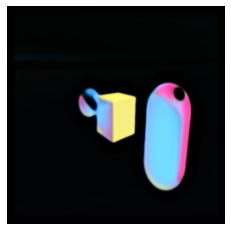

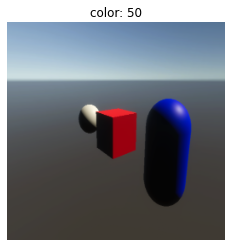

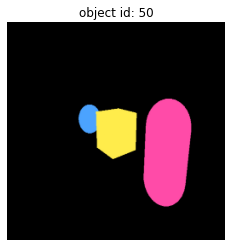

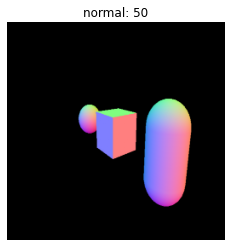

In [7]:
import random

frameid = random.randint(0, primitives_low_res_rgb_test.num_frames - 1)

# test the forward pass
fwdPassImg = modelConvUNet.forward_with_frame(primitives_high_res_rgb_test[frameid])
fwdPassImg.visualize()
primitives_high_res_rgb_test[frameid].visualize()
primitives_high_res_id_test[frameid].visualize()
primitives_high_res_normal_test[frameid].visualize()

# # test the forward pass
# fwdPassImg = modelConvUNet.forward_with_frame(primitives_low_res_rgb_test[frameid])
# fwdPassImg.visualize()
# primitives_low_res_rgb_test[frameid].visualize()
# primitives_low_res_id_test[frameid].visualize()